In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import least_squares
from astropy.coordinates import SkyCoord
from astropy import units as u
import peakutils
from astropy.time import Time as aTime

import datetime as dt, time

import pandas as pd

In [2]:
def get_file(path):
    #opens and external file and makes it into a list
    fopen = path
    f=open(fopen, 'r+')
    g=list(f)
    g=map(lambda s: s.strip(), g)
    f.close()
    return np.array(list(g))

def splitt(old_list):
    #splits the list entries into sublists
    new_list=[]
    for i in old_list:
        new_list+=[i.split()]
    return new_list

def splitt2(old_list,char):
    #splits the list entries into sublists
    new_list=[]
    for i in old_list:
        new_list+=[i.split(char)]
    return np.array(new_list)

def calendar_array(dates, data):
    i, j = zip(*[d.isocalendar()[1:] for d in dates])
    i = np.array(i) - min(i)
    j = np.array(j) - 1
    ni = max(i) + 1

    calendar = np.nan * np.zeros((ni, 7))
    calendar[i, j] = data
    return i, j, calendar


def calendar_heatmap(ax, dates, data):
    i, j, calendar = calendar_array(dates, data)
    im = ax.imshow(calendar, interpolation='none', cmap='jet')
    label_days(ax, dates, i, j, calendar)
    label_months(ax, dates, i, j, calendar)
    ax.figure.colorbar(im)

    
def label_days(ax, dates, i, j, calendar):
    ni, nj = calendar.shape
    day_of_month = np.nan * np.zeros((ni, 7))
    day_of_month[i, j] = [d.day for d in dates]

    for (i, j), day in np.ndenumerate(day_of_month):
        if np.isfinite(day):
            ax.text(j, i, int(day), ha='center', va='center')

    ax.set(xticks=np.arange(7), 
           xticklabels=['M', 'T', 'W', 'R', 'F', 'S', 'S'])
    ax.xaxis.tick_top()

    
def label_months(ax, dates, i, j, calendar):
    month_labels = np.array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                             'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    months = np.array([d.month for d in dates])
    uniq_months = sorted(set(months))
    yticks = [i[months == m].mean() for m in uniq_months]
    labels = [month_labels[m - 1] for m in uniq_months]
    ax.set(yticks=yticks)
    ax.set_yticklabels(labels, rotation=90)

In [3]:
# loading in 2023 and 2024 IVS catalogs

ivs_legacy = [s.split('|')[2:-7] for s in open('master2023.txt').readlines()[8:-1] if s[0]!='-'] + [s.split('|')[2:-7] for s in open('master2024.txt').readlines()[8:-1] if s[0]!='-']
ivs_intens = [s.split('|')[2:-7] for s in open('master2023-int.txt').readlines()[8:-1] if s[0]!='-'] + [s.split('|')[2:-7] for s in open('master2024-int.txt').readlines()[8:-1] if s[0]!='-']
ivs_master = np.array(ivs_legacy+ivs_intens)

In [4]:
''' parsing calendar and getting entried with UTAS telescopes'''

Year     = np.floor(ivs_master[:,0].astype(int)/1e4).astype(int)
yr_day   = (Year%2023)*365
names    = ivs_master[:,1].astype(str)
doy      = ivs_master[:,2].astype(int)
start    = ivs_master[:,3]
st_day   = (splitt2(start,':').astype(float)/np.array([24,3600])).sum(1)
dur      = ivs_master[:,4]
dur_day  = (splitt2(dur,':').astype(float)/np.array([24,3600])).sum(1)
stations = np.array([s.strip(' ').split(' ')[0] for s in ivs_master[:,-1]])
hb = np.array(['Hb' in s for s in stations])
ke = np.array(['Ke' in s for s in stations])
yg = np.array(['Yg' in s for s in stations])
ho = np.array(['Ho' in s for s in stations])
st = [dt.datetime.strptime(f'{Year[i]}-{doy[i]}T{start[i]}',
                           '%Y-%jT%H:%M') for i in range(len(doy))]

sess = hb.astype(int)+ho.astype(int)+ke.astype(int)+yg.astype(int)
#r1   = np.array(['r1' in s for s in names])
#r4   = np.array(['r4' in s for s in names])
sess[sess>1]=1
al = np.ones(len(doy)).astype(bool)

In [5]:
''' making structure to hold information. I've chosen a nday x ntime matrix. 
For one year and every 15mins, this would be 365x96, for every minute it would be 365x1440.
This structure allows me to represent the year/schedule like a google calendar, and flag 15min
intervals as taken or reserved by experiments. 15mins intervals should be sufficient'''

yr   = 3           # years
day  = 365         # days per year
fday = int(24/(0.25))   # 15mins per day = 96

n    = fday*day*yr    # number of intervals per yr years

# making pre-defined numpy arrays to fill/blank
year   = np.arange(n).reshape(int(yr*day),fday)/float(fday)
tmplate = np.zeros(n).reshape(int(yr*day),fday)
year_hb = np.zeros(n).reshape(int(yr*day),fday)
year_ho = np.zeros(n).reshape(int(yr*day),fday)
year_ke = np.zeros(n).reshape(int(yr*day),fday)
year_yg = np.zeros(n).reshape(int(yr*day),fday)
year_al = np.zeros(n).reshape(int(yr*day),fday)
#year_r1 = np.zeros(n).reshape(int(yr*day),fday)
#year_r4 = np.zeros(n).reshape(int(yr*day),fday)


In [6]:
''' using the information from the parsed schedule to get the start/duration of 
experiments involving each telescope for indexing purposes '''

beg_hb,stop_hb = (st_day+doy+yr_day)[hb], (st_day+doy+dur_day+yr_day)[hb]
beg_ho,stop_ho = (st_day+doy+yr_day)[ho], (st_day+doy+dur_day+yr_day)[ho]
beg_ke,stop_ke = (st_day+doy+yr_day)[ke], (st_day+doy+dur_day+yr_day)[ke]
beg_yg,stop_yg = (st_day+doy+yr_day)[yg], (st_day+doy+dur_day+yr_day)[yg]

#beg_r1,stop_r1 = (st_day+doy+yr_day)[r1], (st_day+doy+dur_day+yr_day)[r1]
#beg_r4,stop_r4 = (st_day+doy+yr_day)[r4], (st_day+doy+dur_day+yr_day)[r4]

beg_al,stop_al = (st_day+doy+yr_day)[~(~yg*~ke*~ho)], (st_day+doy+dur_day+yr_day)[~(~yg*~ke*~ho)]

for i in range(len(beg_hb)):
    year_hb[np.where((year>beg_hb[i])*(year<stop_hb[i]))] = 1
    
for i in range(len(beg_ho)):
    year_ho[np.where((year>beg_ho[i])*(year<stop_ho[i]))] = 1
    
for i in range(len(beg_ke)):
    year_ke[np.where((year>beg_ke[i])*(year<stop_ke[i]))] = 1    

for i in range(len(beg_yg)):
    year_yg[np.where((year>beg_yg[i])*(year<stop_yg[i]))] = 1
    
for i in range(len(beg_al)):
    year_al[np.where((year>beg_al[i])*(year<stop_al[i]))] = 1
    
#for i in range(len(beg_r1)):
#    year_r1[np.where((year>beg_r1[i])*(year<stop_r1[i]))] = 1

#for i in range(len(beg_r4)):
#    year_r4[np.where((year>beg_r4[i])*(year<stop_r4[i]))] = 1

In [7]:
#year_r1_24 = np.copy(tmplate)
#year_r4_24 = np.copy(tmplate)
# # first monday of 2023 is day 2
# # r1s are always 17ut tuesday to 17ut wednesday
# # r4s are always 18:30ut wed to 18:30ut thurs

# # first dow in 2023 is sunday == 6
dow = np.zeros(int(yr*day))
dow = np.tile(np.roll(np.arange(7),2),53*yr)[:dow.shape[0]]
dow = np.repeat(dow,96).reshape(int(yr*day),fday)
DoW = dow.flatten()

''' 9-5 "Monday" in AEST/AEDT is basically Sunday 2100-Monday 0700 UT. 
We should reserve this time for testing etc'''

monday = np.zeros(n).reshape(int(yr*day),fday)
# set Sunday UT>21 
monday[(dow[:,0]==6),int(22*60/15):] = 1
# set Monday UT<7
monday[(dow[:,0]==0),:int(3*60/15)] = 1

In [8]:
year_res = year_al + monday
year_res[year_res>=1] = 1

In [9]:
year.shape

(1095, 96)

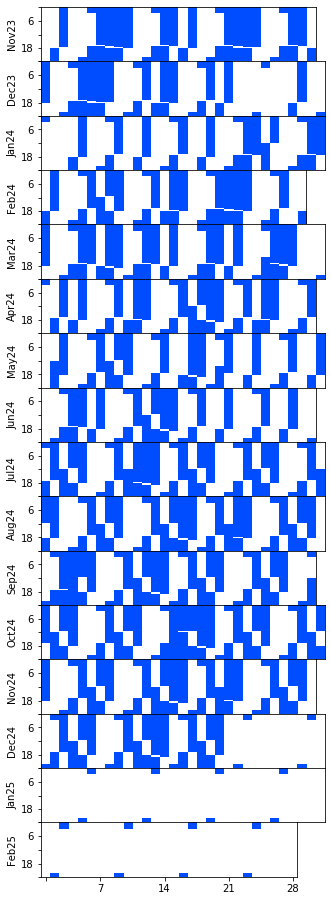

In [10]:
mnth_day = []

plotin = np.copy(year_res) #
plotin[plotin==0] = np.nan

for i in range(12):
    mnth_day.append(dt.datetime(2023,i+1,1).timetuple().tm_yday)
for i in range(12):
    mnth_day.append(365+dt.datetime(2024,i+1,1).timetuple().tm_yday)
for i in range(12):
    mnth_day.append(365+366+dt.datetime(2025,i+1,1).timetuple().tm_yday)
    
mnth_day.append(365+366+365+1)

month_labels = np.array(['Jan23', 'Feb23', 'Mar23', 'Apr23', 'May23', 'Jun23', 'Jul23',
                             'Aug23', 'Sep23', 'Oct23', 'Nov23', 'Dec23',
                         'Jan24', 'Feb24', 'Mar24', 'Apr24', 'May24', 'Jun24', 'Jul24',
                             'Aug24', 'Sep24', 'Oct24', 'Nov24', 'Dec24',
                        'Jan25', 'Feb25', 'Mar25', 'Apr25', 'May25', 'Jun25', 'Jul25',
                             'Aug25', 'Sep25', 'Oct25', 'Nov25', 'Dec25'])
start = 10 #nov23
stop  = 26 #dec24
fig, ax = plt.subplots(stop-start,1,figsize=(12,16))

for i in range(start,stop):
    k = i - start; 
    j = 0
    col = ax[k+j].imshow(plotin.T[:,(mnth_day[i]):(mnth_day[i+1])],
                 cmap='jet',aspect=0.0625,vmin=0,vmax=5);
    ax[k+j].set_ylabel(month_labels[i])
    #ax[k+j].invert_yaxis()
    ax[k+j].set_yticks([0,24,48,72,95])
    ax[k+j].set_yticklabels(['',6,'',18,''])
    #ax[i].hlines(np.arange(0.5, 96, 24), 0, 365, color='black', linewidth=1)
    
    if i!=stop-1: 
        ax[k+j].set_xticks([])
    else: 
        ax[k+j].set_xticks([0,6,13,20,27])
        ax[k+j].set_xticklabels(['',7,14,21,28])


for AX in ax.flatten():
    AX.set_anchor('W')
    
fig.subplots_adjust(hspace=0)
#fig.savefig('/Users/Lucas/SpiralsSchedules/year3schedules/ivs_r1r4.pdf')

In [11]:
time      = year.flatten()
reserved  = (year_res).flatten()

In [12]:
#startstop = (np.where(np.roll(ivs,+1) != ivs)[0]-1)+1
# start = startstop[0::2] # index of start
# stop  = startstop[1::2] # index of stop
# dur = (stop - start)/4

# #format
# #|IVS-R1      |20230103|r11084      |  3|17:00|24:00|AgHbHtIsKeKkKvMaNsOnWzYg -Ny                          |NASA|BONN|20230124| XA |NASA|  20|

# for i in range(start.shape[0]):
#     if DoW[start[i]] == 1: exp = 'r1'; sked='NASA'; corr='BONN'
#     elif DoW[start[i]] == 3: exp = 'r4'; sked='UNSO'; corr='WASH'
#     else: exp = ' '; corr = '    '; sked = '    '
#     doy = np.floor(time[start[i]])%365
#     yr  = time[start[i]]//365 #+ 2023
#     mnt = np.where(time[start[i]]>mnth_day)[0][-1]
#     hr = time[start[i]]%1*24.0//1
#     mn = time[start[i]]%1*24.0%1*60
#     day = np.floor(time[start[i]] - mnth_day[np.where(time[start[i]]>mnth_day)[0][-1]]) + 1
#     if mn>55: hr,mn = hr+1, 0
#     print(f'|IVS-{exp:2s}     |{yr+2023:4.0f}{mnt+1-(yr)*12:02.0f}{day:02.0f}|{exp:2s}    |{doy:3.0f}|{hr:02.0f}:{mn:02.0f}|24:00|HbKeYgHo? |{sked:4s}|{corr:4s}|')

In [13]:
#G291.274-0.709   s14   11h11m53.35s  -61d18m23.7s  |Jun  7|Dec  6|Feb 27|Aug 27| 1.0|
#G299.772-0.005   s15   12h23m48.97s  -62d42m25.3s  |Jun 27|Dec 26|Mar 15|Sep 12| 1.0|
#G318.948-0.196   s16   15h00m55.40s  -58d58m52.1s  |Aug  7|Feb  6|Apr 22|Oct 19| 1.4|
#G326.475+0.703   s17   15h43m16.64s  -54d07m14.6s  |Aug 17|Feb 17|May  1|Oct 29| 1.6|

#G328.237-0.547   s18   15h57m58.28s  -53d59m22.7s  |Aug 21|Feb 21|      |      | 1.7|
#G329.029-0.205   s19   16h00m31.80s  -53d12m49.6s  |Aug 22|Feb 21|      |      | 1.7|
#G332.295+2.280   s20   16h05m41.72s  -49d11m30.3s  |Aug 23|Feb 23|      |      | 1.9|
#G337.920-0.456   s21   16h41m06.05s  -47d07m02.5s  |Aug 31|Mar  3|      |      | 2.3|
#G345.010+1.792   s22   16h56m47.58s  -40d14m25.8s  |Sep  4|Mar  7|      |      | 3.1|
#G348.550-0.979   s23   17h19m20.41s  -39d03m51.6s  |Sep  9|Mar 12|      |      | 3.5|
#G352.630-1.067   s24   17h31m13.91s  -35d44m08.7s  |Sep 12|Mar 15|      |      | 4.5|

In [14]:
'''we need to make matching calendar structures for utc and ceduna sidereal time'''

yr   = 3           # years
day  = 365         # days per year
fday = int(24/(0.25))   # 15mins per day = 96

n    = fday*day*yr    # number of intervals per yr years

utc_2023 = aTime(dt.datetime(2023,1,1,0,0,0),location=(133.6763,-32.1260))
#utc_2024 = aTime(dt.datetime(2024,1,1,0,0,0),location=(133.6763,-32.1260))

dst_day = 24*60/365.25
dst_hr  = dst_day/24.
dst_qhr = dst_hr/4.

# ceduna sidereal time at 1st day/hour/min/sec of year
sid_2023 = utc_2023.sidereal_time('mean').value
#sid_2024 = utc_2024.sidereal_time('mean').value

sid_year_ced = (np.arange(n)*(dst_qhr+15))/60.
sid_ced = (sid_year_ced+sid_2023).reshape(int(yr*day),fday)
# removing day offsets
for i in range(day*yr):
    sid_ced[i,:] = sid_ced[i,:]-24.*i

# unwrapping days
sid_ced[np.where(sid_ced > 24)]+=-24
sid_ced[np.where(sid_ced > 24)]+=-24

sid_ced[np.where(sid_ced > 24)]+=-24
sid_ced[np.where(sid_ced > 24)]+=-24

In [15]:
# masers = [
#  [13+50/60.,  [7, 20], [ 1, 19]],   # s14
#  [11+11/60.,  [6,  7], [12,  6]],   # s15
#  [12+23/60.,  [6, 27], [12, 26]],   # s16
#  [15+ 0/60.,  [8,  7], [ 2,  6]],   # s17
#  [15+43/60.,  [8, 17], [ 2, 17]],   # s18
#  [15+57/60.,  [8, 21], [ 2, 21]],   # s19
#  [16+ 0/60.,  [8, 22], [ 2, 21]],   # s20
#  [16+ 5/60.,  [8, 23], [ 2, 23]],   # s21
#  [16+41/60.,  [8, 31], [ 3,  3]],   # s22
#  [16+56/60.,  [9,  4], [ 3,  7]],   # s23
#  [17+19/60.,  [9,  9], [ 3, 12]],   # s24
#  [17+31/60.,  [9, 12], [ 3, 15]]]   # s25

# maser ra, peak1, peak2, peak3, name
masers = [
[10+48/60., [0,11,30], [1, 6, 1], [1,11,30],'g287.37+0.64'],  #s3
[11+11/60., [0,12, 7], [1, 6, 8], [1,12, 7],'g291.27-0.70'],  #s14
[12+23/60., [0,12,27], [1, 6,28], [1,12,27],'g299.77-0.00'],  #s15
[13+11/60., [1, 1, 8], [1, 7, 9], [2, 1, 8],'g305.20+0.01'],       
[15+29/60., [1, 2,14], [1, 8,14], [2, 2,14],'g323.45-0.07'],
[16+ 3/60., [1, 2,23], [1, 8,23], [2, 2,23],'g329.40-0.45'],
[16+12/60., [1, 2,24], [1, 8,24], [2, 2,24],'g331.34-0.34'],
[16+41/60., [1, 2,26], [1, 8,26], [2, 2,26],'g337.92-0.45'],
[16+40/60., [1, 3, 4], [1, 9, 1], [2, 3, 4],'g338.92+0.55']
]


In [16]:
# # this version works - stepping (there is a bug but saving)

# class failed(Exception): pass

# span   = 45 # days
# emax   = mas_up.shape[0] # days
# emin   = 365-31

# ivs_res= year_al.flatten()

# slots = np.delete(np.array(sorted(np.arange(-span+1,span),key=abs)),0)

# #season index for epochs
# season    = [ 0,0,0,  1, 1,1,1, 1, 2,2,2]
# offs_peak = [-7,0,7,-14,-7,0,7,14,-7,0,7]

# rng = np.arange(len(masers)*11)
# frame = []
# for i in range(len(masers)):
#     for j in range(11):
#         frame.append([i, j])

# packed     = True
# best_count = 99
# for trys in range(1000):
#     # zero solutions
#     mobs   = np.zeros(shape=(len(masers),11))
#     mas_up = np.copy(tmplate)

#     # new maser, epoch shuffle
#     np.random.shuffle(rng)
#     rframe= []
#     for r in rng:
#         rframe.append(frame[r])
    
#     # loop over masers and epochs
#     for mas,epoch in rframe:
#         ra  = masers[mas][0]
#         pyr,mnt,day = masers[mas][1:-1][season[epoch]]
#         pday        = mnth_day[mnt-1+12*pyr] + day + offs_peak[epoch]
#         for slot in slots:
#             eday = pday + slot
#             if eday < emin:
#                 continue
#             # check if the day/time is reserved by IVS
#             ivs_res = np.any(year_res[eday,(abs(sid_ced[eday%365,:]-ra)<4)].astype(bool)) 

#             # check if the day is already reserved by spirals
#             spi_res = np.any((mas_up[eday,(abs(sid_ced[eday%365,:]-ra)<4)]>0).astype(bool))

#             if ~ivs_res and ~spi_res:
#                 # if the time is unreserved, lets reserve it and move to next epoch
#                 mas_up[eday,(abs(sid_ced[eday%365,:]-ra)<4)] = 3+mas
#                 # store the day
#                 mobs[mas,epoch] = eday
#                 break
#             else: 
#                 continue
#     # check final solution
#     packed = np.any(np.diff(np.sort(mobs,axis=1))<4)
#     if ~packed: 
#         break
#     else: 
#         count = np.sum(np.diff(np.sort(mobs,axis=1))<4)
#         if count<best_count:
#             best_count = count
#             best = np.sort(mobs,axis=1)
# print(best_count)

In [18]:
# this version doesn't work yet - stepping but linear time

class failed(Exception): pass


mas_up = np.copy(tmplate)
span   = 60 # days
emax   = mas_up.shape[0] # days
emin   = 344
min_ha = 4

year_r = year_res.flatten()

slots = np.delete(np.array(sorted(np.arange(-span+1,span),key=abs)),0)

#season index for epochs
season    = [ 0,0,0,  1, 1,1,1, 1, 2,2,2]
offs_peak = [-7,0,7,-14,-7,0,7,14,-7,0,7]

rng = np.arange(len(masers)*11)
frame = []
for i in range(len(masers)):
    for j in range(11):
        frame.append([i, j])

packed     = True
best_count = 99
for trys in range(10000):
    #print(trys)
    #print('-------------')
    # zero solutions
    mobs   = np.zeros(shape=(len(masers),11))
    mas_up = np.copy(tmplate).flatten()

    # new maser, epoch shuffle
    np.random.shuffle(rng)
    rframe= []
    for r in rng:
        rframe.append(frame[r])
    
    # loop over masers and epochs
    for mas,epoch in rframe:
        #print(mas,epoch)
        ra  = masers[mas][0]
        pyr,mnt,day = masers[mas][1:-1][season[epoch]]
        # get peak day
        pday        = mnth_day[mnt-1+12*pyr]+day+offs_peak[epoch]
        #print(pday)
        for slot in slots:
            # try UT epoch start day
            eday = int(pday + slot + np.random.normal(0,7))
            if eday < emin:
                #print('Too early')
                continue
            # calculate rise time (as an index) of maser on UT day
            rise_indx = abs(sid_ced[eday%365,:] - ra - min_ha).argmin()
            
            # check if the day/time is reserved by IVS
            ivs_res = np.any(year_r[(eday*96+rise_indx):(eday*96+rise_indx+32)].astype(bool)) 

            # check if the day is already reserved by spirals
            spi_res = np.any((mas_up[(eday*96+rise_indx):(eday*96+rise_indx+32)]>0))

            if ~ivs_res and ~spi_res:
                #print('Found a spot: '+str(slot))
                # if the time is unreserved, lets reserve it and move to next epoch
                mas_up[(eday*96+rise_indx):(eday*96+rise_indx+32)] = 3+mas
                # store the day
                mobs[mas,epoch] = eday
                #print(mobs)
                break
            else: 
                #print('Slot '+str(slot)+ ' reserved')
                continue
    # check final solution
    packed = np.any(np.diff(np.sort(mobs,axis=1))<4)
    if ~packed: 
        print('She good')
        break
    else: 
        count = np.sum(np.diff(np.sort(mobs,axis=1))<4)
        if count<best_count:
            best_count = count
            best = np.sort(mobs,axis=1)
print(best_count)

3


In [19]:
best

array([[344., 350., 364., 497., 515., 519., 526., 540., 693., 697., 708.],
       [347., 351., 358., 501., 511., 518., 536., 546., 701., 715., 731.],
       [354., 361., 369., 525., 533., 553., 561., 568., 711., 729., 739.],
       [362., 371., 376., 508., 543., 547., 554., 575., 727., 742., 749.],
       [  0., 399., 407., 410., 582., 589., 602., 610., 759., 781., 800.],
       [392., 414., 440., 581., 588., 596., 609., 665., 774., 783., 796.],
       [406., 421., 428., 567., 603., 616., 638., 645., 778., 780., 784.],
       [413., 420., 432., 539., 549., 624., 631., 644., 776., 790., 799.],
       [425., 427., 442., 574., 617., 630., 637., 651., 791., 795., 818.]])

In [2340]:
rise_ind = np.zeros(shape=(len(masers),3*365))
for mas in range(len(masers)):
    ra  = masers[mas][0]
    ha = sid_ced - ra
    rise_ind[mas,:] = abs(ha - 4).argmin(1)


In [2399]:
rise_ind[:,330]/4

array([1.5 , 2.  , 3.  , 4.  , 6.25, 6.75, 7.  , 7.25, 7.25])

In [20]:
# setting to m if required

# best = np.array([
#        [359., 363., 364., 483., 505., 508., 515., 536., 683., 707., 720.],
#        [344., 347., 366., 501., 512., 525., 539., 547., 687., 724., 732.],
#        [351., 361., 372., 511., 533., 543., 554., 568., 704., 711., 741.],
#        [354., 378., 391., 540., 553., 561., 582., 589., 718., 732., 750.],
#        [  0., 397., 413., 425., 574., 602., 616., 653., 756., 770., 793.],
#        [  0., 386., 407., 455., 588., 603., 624., 673., 764., 771., 797.],
#        [403., 414., 421., 546., 581., 609., 617., 644., 783., 791., 808.],
#        [376., 424., 439., 567., 610., 630., 637., 645., 773., 780., 806.],
#        [427., 435., 453., 596., 631., 638., 651., 652., 774., 775., 809.]])

m = np.array([
[ 336.,  371.,  378.,  505.,  512.,  519.,  526.,  533.,  870., 877.,  884.],
[ 329.,  343.,  364.,  491.,  502.,  515.,  523.,  540.,  679., 693.,  888.],
[ 350.,  368.,  382.,  539.,  546.,  553.,  581.,  588.,  721., 904.,  911.],
[ 356.,  367.,  385.,  518.,  534.,  543.,  571.,  596.,  883., 899.,  908.],
[ 375.,  392.,  441.,  575.,  582.,  590.,  597.,  630.,  955., 962.,  995.],
[ 413.,  420.,  427.,  602.,  609.,  616.,  624.,  645.,  967., 989., 1010.],
[ 424.,  448.,  455.,  589.,  603.,  610.,  617.,  631.,  954., 968.,  996.],
[ 399.,  406.,  457.,  562.,  568.,  583.,  604.,  648.,  933., 948., 1013.],
[ 454.,  462.,  469.,  569.,  611.,  618.,  625.,  652.,  934., 976., 1017.]])

mas_up = np.copy(tmplate).flatten()
#print(masers)

for i in range(len(masers)):
    for epoch in range(11):
        ra  = masers[i][0]
        rise_indx = abs(sid_ced[int(best[i,epoch])%365,:] - ra - min_ha).argmin()
        mas_up[(int(best[i,epoch])*96+rise_indx):(int(best[i,epoch])*96+rise_indx+32)] = i+1

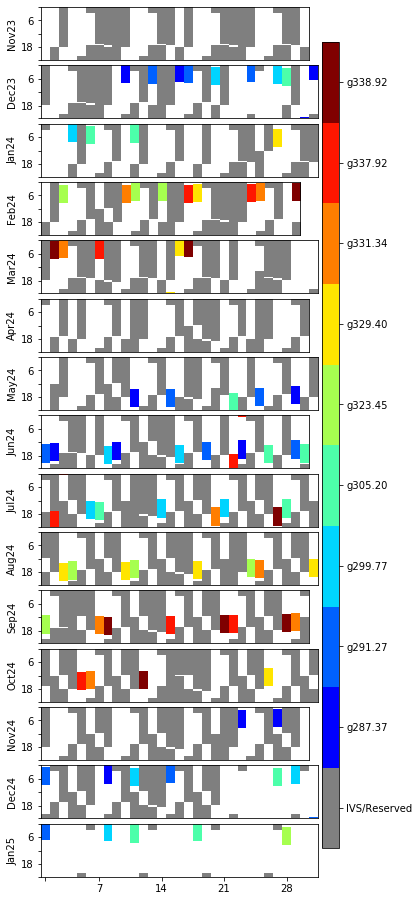

In [21]:
plotin =  np.copy(mas_up.reshape(3*365,96))
plotin[plotin==0] = np.nan
plotin[np.where((year_al+monday)>=1)] = 0
#plotin[np.where(mas_up!=0)] = 2
#plotin[np.where((year_al==1)*(mas_up!=0))] = 3

#mas_up + year_al #+  mas_up #+ monday

cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 10, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

start = 10 #jul23
stop  = 25 #dec24
fig, ax = plt.subplots(stop-start,1,figsize=(12,16))

for i in range(start,stop):
    k = i - start; j = 0
    col = ax[k+j].imshow(plotin.T[:,(mnth_day[i]):(mnth_day[i+1])],
                 cmap=cmap, norm=norm,aspect=0.0625,vmin=0,vmax=9);
    ax[k+j].set_ylabel(month_labels[i])
    #ax[k+j].invert_yaxis()
    ax[k+j].set_yticks([0,24,48,72,95])
    ax[k+j].set_yticklabels(['',6,'',18,''])
    #ax[i].hlines(np.arange(0.5, 96, 24), 0, 365, color='black', linewidth=1)
    
    if i!=stop-1: ax[k+j].set_xticks([])
    else: 
        ax[k+j].set_xticks([0,6,13,20,27])
        ax[k+j].set_xticklabels(['',7,14,21,28])

for AX in ax.flatten():
    AX.set_anchor('W')
cbar_ax = fig.add_axes([0.45, 0.15, 0.02, 0.7])  
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(hspace=0.1,wspace=0.1)
cb = fig.colorbar(col,cax=cbar_ax)  
cb.set_ticks([.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5])
cb.set_ticklabels(['IVS/Reserved']+[s[-1][:7] for s in masers])
#fig.savefig('/Users/Lucas/masers_up_ivs3.pdf',bbox_inches='tight')

11

In [81]:
i    = 1 
doy  = np.floor(Y[start[i]])%365
yr   = Y[start[i]]//365 # + 2023
mnt  = np.where(Y[start[i]]>mnth_day)[0][-1]
hr   = Y[start[i]]%1*24.0//1
mn   = Y[start[i]]%1*24.0%1*60

0.0 344.0 11 0.0 15.000000000027285


In [125]:
namez=['s013','s025','s026','s027',
       's028','s029','s021','s030','s024']

alpha = list(map(chr, range(97, 123)))


M = mas_up.flatten()
#mas_up.flatten()
Y = year.flatten()

start = np.where(np.diff(M)>0)[0]

# #format
#print('|IVS-R1      |20230103|r11084      |  3|17:00|24:00|AgHbHtIsKeKkKvMaNsOnWzYg -Ny                          |NASA|BONN|20230124| XA |NASA|  20|')

done = []

for i in range(start.shape[0]):
    exp  = namez[int(M[start[i]+1])-1]
    done.append(exp)
    ep_lab = np.sum(np.array(done)==exp)
    expl = exp+alpha[ep_lab-1]
    sked  = 'UTAS'
    corr  = 'UTAS'
    try:
        doy  = np.floor(Y[start[i]])%365
        yr   = Y[start[i]]//365 #+ 2023
        mnt  = np.where(Y[start[i]]>mnth_day)[0][-1]
        hr   = Y[start[i]]%1*24.0//1
        mn   = Y[start[i]]%1*24.0%1*60
        day  = np.floor(Y[start[i]] - mnth_day[np.where(Y[start[i]]>mnth_day)[0][-1]])+1
        if mn>55: hr,mn = hr+1, 0
        print(f'|SPIRALS     |{yr+2023:4.0f}{mnt+1-(yr)*12:02.0f}{day:02.0f}|{expl:2s}    |{doy:3.0f}|{hr:02.0f}:{mn:02.0f}|08:00|CdHoKeYgWaHb? |{sked:4s}|{corr:4s}|')
    except IndexError:
        continue


|SPIRALS     |20231210|s013a    |344|00:15|08:00|CdHoKeYgWaHb? |UTAS|UTAS|
|SPIRALS     |20231213|s025a    |347|00:30|08:00|CdHoKeYgWaHb? |UTAS|UTAS|
|SPIRALS     |20231216|s013b    |350|00:00|08:00|CdHoKeYgWaHb? |UTAS|UTAS|
|SPIRALS     |20231217|s025b    |351|00:15|08:00|CdHoKeYgWaHb? |UTAS|UTAS|
|SPIRALS     |20231220|s026a    |354|01:15|08:00|CdHoKeYgWaHb? |UTAS|UTAS|
|SPIRALS     |20231223|s025c    |357|23:45|08:00|CdHoKeYgWaHb? |UTAS|UTAS|
|SPIRALS     |20231227|s026b    |361|00:45|08:00|CdHoKeYgWaHb? |UTAS|UTAS|
|SPIRALS     |20231228|s027a    |362|01:30|08:00|CdHoKeYgWaHb? |UTAS|UTAS|
|SPIRALS     |20231230|s013c    |364|23:00|08:00|CdHoKeYgWaHb? |UTAS|UTAS|
|SPIRALS     |20240104|s026c    |  4|00:15|08:00|CdHoKeYgWaHb? |UTAS|UTAS|
|SPIRALS     |20240106|s027b    |  6|01:00|08:00|CdHoKeYgWaHb? |UTAS|UTAS|
|SPIRALS     |20240111|s027c    | 11|00:30|08:00|CdHoKeYgWaHb? |UTAS|UTAS|
|SPIRALS     |20240127|s029a    | 27|02:30|08:00|CdHoKeYgWaHb? |UTAS|UTAS|
|SPIRALS     |20240203|s0